In [ ]:
%%capture
!pip install awscli

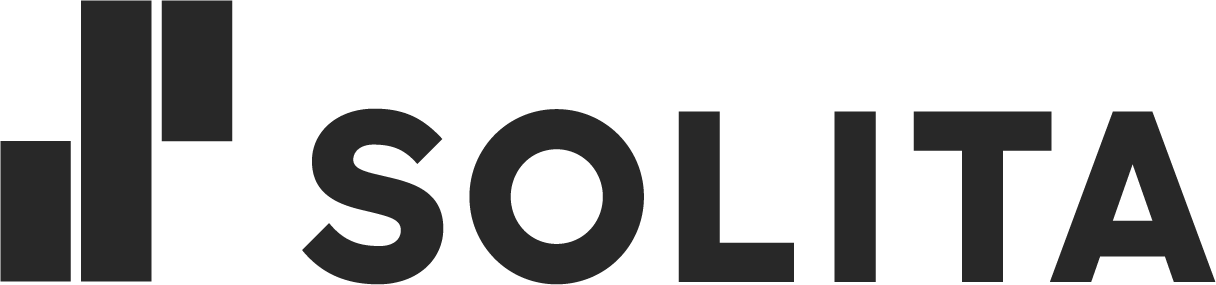

# Solita NLP - Johdatus datatieteisiin
Vierailuluento 13.4.2021

(Slide aiheesta Teemu Mikkonen / Solita)

## Mitä NLP on?

- Yksi datatieteiden erityisala, jossa datalähteenä on luonnollinen kieli
- Luonnollinen kieli on luonteeltaan rakenteetonta, joka asettaa datatieteiden näkökulmasta haasteita siinä, miten sitä voidaan käyttää datalähteenä.
- Olennaista on tekstin esikäsittely ja piirteiden erottaminen, jotka tähtäävät tietynlaiseen rakenteen luomiseen ja tekstin muuntamiseen laskettavaan, numeraaliseen muotoon.
- Yleisiä NLP:n käyttökohteita ovat mm. chatbotit, automaattiset konekäännökset, tekstin luokittelu ja tekstimassojen (korpus) analysointi
- NLP ei usein ole vain yksin käytetty käyttötapaus, vaan se usein linkittyy johonkin muuhun data/koneoppimisratkaisuun. NLP:n avulla voidaan esimerkiksi tehdä piirteiden eroitus, jolloin saadaan opetusdataan yksi ulottuvuus lisää.

## Google Colaboratory

- Googlen ylläpitämä ilmainen Notebook-palvelu
- Helppo jakaa koodia ja työskennellä yhdessä mm. dataprojekteissa.
- Saatavilla myös laskentatehoa (GPU & TPU -prosessointi)
  >- Yläpalkki
  >- Runtime
  >- Change runtime type
  >- Hardware accelerator
  >- GPU 

- Tähän harjoitukseen ei kuitenkaan tarvita lisälaskentatehoa (fastText-työkalu on CPU-pohjainen)
- HUOM. Saatavat laskentaresurssit riippuvat vapaana olevasta kapasiteetista, laskentateho ei näin ollen ole vakio. 

#### Hyödyllisiä pikakomentoja
> - ctrl/cmd + enter = suorita solu
> - shift + enter = suorita solu ja siirry seuraavaan
> - ctrl/cmd + m + b = luo solu alapuolelle
> - ctrl/cmd + m + b = luo solu yläpuolelle
> - ctrl/cmd + d + d = poista solut



## Eduskuntadatan luokittelu - ministerien vastaukset kirjallisiin kysymyksiin

Data haettu repostoriosta https://github.com/aajanki/eduskunta-vkk (Antti Aajanki)

Tähän esimerkkiin tarvittava data, sekä listaus tarvittavista Python-kirjastoista ladataan AWS S3-palvelusta

In [ ]:
#Haetaan pakettidata ja hukkasanalista avoimesta AWS S3-bucketista
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/requirements.txt requirements.txt
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/stopwords.txt stopwords.txt

download: s3://nlpluentomateriaalit/requirements.txt to ./requirements.txt


In [ ]:

#Asennetaan tarvittavat kirjastot haetun requirements-tiedoston perusteella
!pip install -r requirements.txt

#Asennetaan voikko-kirjasto suoraan versionhallinnasta
!sudo apt -y install -y voikko-fi python-libvoikko

     |████████████████████████████████| 10.5MB 1.1MB/s 
  Found existing installation: pandas 1.0.4
    Uninstalling pandas-1.0.4:
      Successfully uninstalled pandas-1.0.4


Reading package lists... Done
Building dependency tree       
Reading state information... Done
voikko-fi is already the newest version (2.2-1).
python-libvoikko is already the newest version (4.1.1-1.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


Imporit ja hukkasanalistan käsittely

In [ ]:
import pandas as pd 
import numpy as np
import logging
import libvoikko #perusmutoistamiseen käyttetty kirjast
import fasttext as ft #Mallin opetuskseen käytettävä kirjasto
#import nltk #Natural Language Toolkit, hyödyllisiä NLP-perustyökaluja
import re #Regex

v = libvoikko.Voikko(u"fi")

with open('stopwords.txt', 'r', encoding='utf8') as sw:
    stopwords = sw.readlines()
    sw.close()

stopwords = [i.split("\n")[0] for i in stopwords]

### Stopwordit / Hukkasanat
- Sanoja jotka eivät lisää tekstikorpuksen informaatioarvoa
- NLP-datan "kohinaa"
- Prepositioita, partikkeleita yms.
- Tässä esimerkissä myös suomen kielen yleisimpiä erisnimiä
- Voidaan tehdä toimialakohtaisesti
  - Jonkun alan hukkasana voi olla tärkeä toisella alalla
  - Esimerkki? 

In [ ]:
print(stopwords[20:40])

['aika', 'aikaa', 'aikaan', 'aikaisemmin', 'aikaisin', 'aikajen', 'aikana', 'aikoina', 'aikoo', 'aikovat', 'aina', 'ainakaan', 'ainakin', 'ainoa', 'ainoat', 'aiomme', 'aion', 'aiotte', 'aist', 'aivan']


---
# Datan lukeminen




Luetaan data edellämainitusta S3-bucketista ja puretaan bzip2-pakatut tiedostot. Data on jo valmiiksi jaettu opetus- ja testijoukkoon.

In [ ]:
!mkdir data
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/train.csv.bz2 data/train.csv.bz2
!aws s3 --no-sign-request cp s3://nlpluentomateriaalit/test.csv.bz2 data/test.csv.bz2
!bzip2 -d "data/train.csv.bz2"
!bzip2 -d "data/test.csv.bz2"

mkdir: cannot create directory ‘data’: File exists
download: s3://nlpluentomateriaalit/train.csv.bz2 to data/train.csv.bz2
download: s3://nlpluentomateriaalit/test.csv.bz2 to data/test.csv.bz2
bzip2: Output file data/train.csv already exists.
bzip2: Output file data/test.csv already exists.


Luetaan data csv-tiedostosta Pandas DataFrameen

In [ ]:
df_train = pd.read_csv('data/train.csv').drop_duplicates()
df_test = pd.read_csv('data/test.csv').drop_duplicates()

### Analyysi

Tutustutaan hieman tarkemmin dataan, jota tässä esimerkissä käytetään. Pandas dataframen .head()-funktio näyttää jokaisen sarakkeen viisi ensimmäistä riviä, ja .info() näyttää sarakkeiden tietotyypit ja rivimäärän.

In [ ]:
df_train.head()

,sentence,ministry
0,Hallituksen esityksen 43/2016vp valmistelussa ...,sisäministeri
1,Suojaosuuden nostaminen vähentäisi kaikkien ve...,oikeus- ja työministeri
2,Edistämällä puun käyttöä rakentamisessa tuetaa...,maatalous- ja ympäristöministeri
3,Valvira ja aluehallintovirastot ovat ottaneet ...,perhe- ja peruspalveluministeri
4,Lainmuutoksessa säädettiin vaativan lääkinnäll...,sosiaali- ja terveysministeri


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49106 entries, 0 to 49105
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  49106 non-null  object
 1   ministry  49106 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


Opetusdatan ja testidatan suhde on syytä selvittää, sillä jakoa ei ole muodostettu itse

In [ ]:
df_test.shape[0] / df_train.shape[0] = 

0.06109233087606403

### Opetusdata ja labelit

Varsinaiseen opetusdataan on syytä pureutua tarkemmin, sillä opetuksen kannalta on merkittävää, kuinka paljon kullekin luokalle on opetusdatassa rivejä. Mikäli ero on merkittävä, se voi aiheuttaa opetuksen painottumista niihin tunnisteisiin, joille on eniten opetusdataa. 

Tämän vuoksi datasettejä on joskus tarpeen tasapainottaa joko yliotannan tai aliotannan menetelmin. Yliotannassa datasettiin voidaan luoda keinotekoisia arvoja, jotka ovat lähellä kyseisen tunnisteen datapisteitä. Aliotannassa karsitaan yleisimpien luokkien datapisteiden määrää, jotta luokkien datapisteet ovat jakautuvat tasaisemmin.

In [ ]:
#Opetusdatan luokkien jakauma /TODO visu? 
df_train["ministry"].value_counts()

perhe- ja peruspalveluministeri              7923
maatalous- ja ympäristöministeri             7365
oikeus- ja työministeri                      6057
sisäministeri                                5581
opetus- ja kulttuuriministeri                5417
liikenne- ja viestintäministeri              3691
sosiaali- ja terveysministeri                3581
valtiovarainministeri                        2718
elinkeinoministeri                           1931
ulkoministeri                                 946
kunta- ja uudistusministeri                   920
pääministeri                                  798
eurooppa-, kulttuuri- ja urheiluministeri     795
puolustusministeri                            756
ulkomaankauppa- ja kehitysministeri           627
Name: ministry, dtype: int64

Huom. Kuten jakaumasta nähdää, ministerit eivät täysin vastaa niitä salkkuja, joita tällä hetkellä on, koska salkkujen sisältö on myös muuttunut vuosien varrella. Datasetin kehittäjä on yhdistellyt historiadatassa esiintyviä salkkuja, että jakauma pysyy miellyttävänä

Mahdollinen downsampling-esimerkki (tai dropataan pienet luokat)

# Esikäsittely

Esikäsittely on tärkeä vaihe missä vain koneoppimisprosessissa. Sen tarkoitus on:
- Parantaa opetusdatan laatua
- Vähentää kohinaa (dataa, joka vaikeuttaa piirteiden erottamista opetusdatasta
- Muuntaa opetusdata muotoon, jossa sitä voidaan käyttää mallin opetukseen

Tässä NLP-esimerkissä opetusdataa esikäsitellään sekä ennen mallin opettamista, että mallin opetusfunktion sisällä. Esikäsittely, jossa datan laatua parannetaan tehdään manuaalisesti. Varsinainen piirteiden erotus ja teksin muuttaminen numeromuotoon, tässä tapauksessa sanavektoreiksi, tapahtuu opetusfunktiossa. 



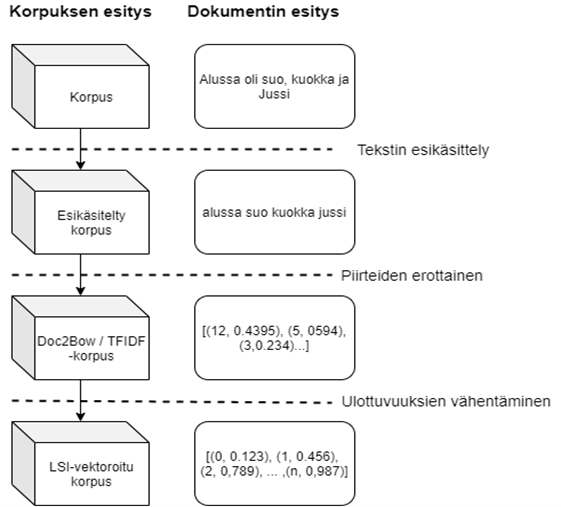

Data on muutettava fastText-mallin opetusta varten muotoon, jossa jokaisella rivillä opetustekstiä edeltää mallin luokka. Esim:
> \_\_label__valtionvarainministeri Lorem ispum dolor sit amet

Tämän jälkeen opetus- ja testidata kirjoitetaan levylle tiedostoksi. 

### Esikäsittely vaiheittain
 - Pienet alkukirjaimet
 - Erikoismerkkien poisto
 - Hukkasanojen poisto
 - (perusmuotoistaminen)
 - (stemmaus)


In [ ]:
text = df_train["sentence"][0]
print("Alkuperäinen teksti: ", text)
text_l = text.lower()
print("Pienet alkukirjaimet: ", text_l)

Alkuperäinen teksti:  Hallituksen esityksen 43/2016vp valmistelussa on arvioitu mahdollisuutta säätää poikkeus turvattua toimeentuloa koskevasta vaatimuksesta tilanteissa , joissa perheenkokoaja on yksin maahan saapunut alaikäinen lapsi .
Pienet alkukirjaimet:  hallituksen esityksen 43/2016vp valmistelussa on arvioitu mahdollisuutta säätää poikkeus turvattua toimeentuloa koskevasta vaatimuksesta tilanteissa , joissa perheenkokoaja on yksin maahan saapunut alaikäinen lapsi .


Poistetaan seuraavaksi tekstistä erikoismerkit, kuten pisteet, pilkut, viivat, kautta-merkit yms.

HUOM! Mikäli tekstissä haluaa säilyttää lauserakenteen (jotkin mallit vaativat lauseittain opetusta, esim Gensim), on se otettava huomioon tässä vaiheessa, sillä pisteet häviävät regex-komennossa

In [ ]:
#Erikoismerkkien poisto:

words = text.split(" ") #Tehdään tekstin sanoista lista, jota voidaan esikäsitellä sana kerralaan

preprocessed_words = [] #Tyhjä lista esikäsitellyille sanoille

for word in words:
  word = re.sub("[^A-Za-z0-9ÄäÖö-]+", "", word) #Poistetaan regexin avulla kaikki merkit paitsi A-Ö-kirjaimet ja numerot
  word = re.sub("-", " ", word) #Muutetaan regex-komennon avulla kaikki väliviivalliset sanat eri sanoiksi vaihtamalla viivan tilalle välilyönti
  word = word.strip().lower() #Poistetaan sanan ympäriltä ylimääräiset välilyönnit ja muutetaan kaikki kirjaimet pieniksi
  preprocessed_words.append(word) #Lisätään sana esikäsiteltyjen sanojen listaan

text_sc = " ".join(preprocessed_words) #Liitetään listan sanat toisiinsa välilyönnein
print("Erikoismerkit poistettu:", text_sc)

Erikoismerkit poistettu: hallituksen esityksen 432016vp valmistelussa on arvioitu mahdollisuutta säätää poikkeus turvattua toimeentuloa koskevasta vaatimuksesta tilanteissa  joissa perheenkokoaja on yksin maahan saapunut alaikäinen lapsi 


Seuraavassa vaiheessa muunnetaan sanat perusmuotoon

In [ ]:
#Käytetään edellisen solun sanalistaa

baseform_words = []

for word in words:
  if type(word) != None: #Ohitetaan ns. tyhjät merkkijoukot
    voikko_dict = v.analyze(word)
    if voikko_dict:
      word = voikko_dict[0]['BASEFORM']
      if word not in stopwords:
        baseform_words.append(word)

text_bf = " ".join(baseform_words)
print("Alkuperäinen:", "\n", text, "\n")
print("Perusmuotoinen:", "\n", text_bf)


Alkuperäinen: 
 Hallituksen esityksen 43/2016vp valmistelussa on arvioitu mahdollisuutta säätää poikkeus turvattua toimeentuloa koskevasta vaatimuksesta tilanteissa , joissa perheenkokoaja on yksin maahan saapunut alaikäinen lapsi . 

Perusmuotoinen: 
 hallitus esitys valmistelu arvioitu mahdollisuus säätää poikkeus turvattu toimeentulo koskeva vaatimus tilanne perheenkokoaja maa saapunut alaikäinen lapsi


Seuraavassa solussa on edelliset vaiheet kirjoitettu funktioksi, joilla on helppo käsitellä koko tekstijoukko opetusta varten

In [ ]:
#TODO Muuta helpommin ymmärrettäväksi

def preprocess_word(word, stopwords):

    word = re.sub("[^A-Za-z0-9ÄäÖö-]+", "", word)
    word = re.sub("-", " ", word)
    word = word.strip().lower()
    
    if type(word) != None:
        voikko_dict = v.analyze(word)
        if voikko_dict:
          word = voikko_dict[0]['BASEFORM']
          if word not in stopwords:
            return word
          else:
              return ""
        else:
            return ""

def preprocess_sent(sent, stopwords):

    if sent != "":
        words = sent.strip().split(" ")
        final_sent = " ".join([preprocess_word(word, stopwords) for word in words if type(word) != None])
        return final_sent

def preprocess_row(teksti, stopwords):

    if type(teksti) == str:
        sents = teksti.strip().split(".")
        sents = filter(None,sents)
        teksti = ".".join([preprocess_sent(sent, stopwords) for sent in sents if type(sent) != None])
        return teksti

FastText-mallin opetus vaatii opetuslabelille tunnisteen, tässä tilanteessa käytetään oletusarvoa \_\_label__

In [ ]:
df = df_train

In [ ]:
df["label"] = ["__label__" + i for i in df_train["ministry"]]
df.head()

KeyError: ignored

Käytetään apufunktiota luomaan uusi dataframeen uusi sarake "Preprocessed"

In [ ]:
df["preprocessed"] = [preprocess_row(sentence, stopwords) for sentence in df["sentence"]]
df.head()

KeyError: ignored

In [ ]:
df["preprocessed"][0]

'hallitus esitys  valmistelu  arvioitu mahdollisuus säätää poikkeus turvattu toimeentulo koskeva vaatimus tilanne   perheenkokoaja   maa saapunut alaikäinen lapsi'

In [ ]:
df.head()

,sentence,ministry,label,preprocessed
0,Hallituksen esityksen 43/2016vp valmistelussa ...,sisäministeri,__label__sisäministeri,hallitus esitys valmistelu arvioitu mahdolli...
1,Suojaosuuden nostaminen vähentäisi kaikkien ve...,oikeus- ja työministeri,__label__oikeus- ja työministeri,suojaosuus nostaa vähentää velallinen hyvät...
2,Edistämällä puun käyttöä rakentamisessa tuetaa...,maatalous- ja ympäristöministeri,__label__maatalous- ja ympäristöministeri,edistää puu käyttö rakentaa tukea metsä kestäv...
3,Valvira ja aluehallintovirastot ovat ottaneet ...,perhe- ja peruspalveluministeri,__label__perhe- ja peruspalveluministeri,aluehallintovirasto ottanut turvapaikanhaki...
4,Lainmuutoksessa säädettiin vaativan lääkinnäll...,sosiaali- ja terveysministeri,__label__sosiaali- ja terveysministeri,lainmuutos säätää vaativa lääkinnällinen kunto...


In [ ]:
#Apufunktio, jolla voidaan luoda fastText-yhteensopiva opetus- ja tekstitiedosto

def preprocess_ft_df(df):
  df["label"] = ["__label__" + "_".join(i.split(" ")) for i in df["ministry"]]
  df["preprocessed"] = [preprocess_row(sentence, stopwords) for sentence in df["sentence"]]
  df = df.drop(["ministry", "sentence"], axis = 1)
  return df

In [ ]:
df_train = preprocess_ft_df(df_train)
df_test = preprocess_ft_df(df_test)

In [ ]:
df_train.head()

,label,preprocessed
0,__label__sisäministeri,hallitus esitys valmistelu arvioitu mahdolli...
1,__label__oikeus-_ja_työministeri,suojaosuus nostaa vähentää velallinen hyvät...
2,__label__maatalous-_ja_ympäristöministeri,edistää puu käyttö rakentaa tukea metsä kestäv...
3,__label__perhe-_ja_peruspalveluministeri,aluehallintovirasto ottanut turvapaikanhaki...
4,__label__sosiaali-_ja_terveysministeri,lainmuutos säätää vaativa lääkinnällinen kunto...


In [ ]:
#df_train = df_train.drop(["ministry", "sentence"], axis = 1)
df_train.to_csv("data/train_ft.txt", sep='\t', index = False, header = False)
df_test.to_csv("data/test_ft.txt", sep='\t', index = False, header = False)

In [ ]:
df_test.head()

,label,preprocessed
0,__label__maatalous-_ja_ympäristöministeri,vaihtoehto voida kotitalousvähennys piiri ...
1,__label__sisäministeri,kielitaitolaki yleinen mahdollisuus säätää p...
2,__label__opetus-_ja_kulttuuriministeri,vanhempi jäädä työtön oikeus kokopäiväinen var...
3,__label__kunta-_ja_uudistusministeri,oikeusministeriö pyytää sijoittamisselvitys e...
4,__label__liikenne-_ja_viestintäministeri,liikenne viestintäministeriö valmiste vaara...


# Mallin opetus

FastText - Facebook research

- Fasttext logo
- Miten fastText-toimii


In [ ]:
#@title Mallin opetusparametrit
#@markdown Input: Polku opetustiedostoon
input = "data/train_ft.txt"#@param {type:"string"}
#@markdown label_prefix: Luokan tunnuksen etuliite
label_prefix = "__label__"#@param {type:"string"}
#@markdown Epoch: Montako kertaa mallin opetus iteroidaan
epoch = 100#@param {type:"number"}
#@markdown Dim: Miten monta ulottuvuutta mallin opettamat sanavektorit sisältävät
dim = 3#@param {type:"number"}
#@markdown Word_ngrams: Minkäkokoisia ngrameja ympäröivistä sanoista muodostetaan
word_ngrams = 3#@param {type:"number"}
#@markdown ws: window size, miten monta ympäröivää sanaa tulkitaan sanan kontekstiksi
ws= 3#@param {type:"number"}

#Mallin opetus tapahtuu komennolla train_supervised ja malli tallennetaan muuttujaan
ft_classifier = ft.train_supervised(
                          input = input,
                          label_prefix = label_prefix,
                          epoch = epoch, 
                          dim = dim,
                          word_ngrams = word_ngrams,
                          ws = ws)



In [ ]:
df_test['text'] = df_test['text'].str.replace("__label__", "")
ft_score = ft_classifier.predict(df_test['text'].tolist(), k=2)

In [ ]:
df_test


,label,preprocseed
0,__label__maatalous- ja ympäristöministeri,vaihtoehto voida kotitalousvähennys piiri ...
1,__label__sisäministeri,kielitaitolaki yleinen mahdollisuus säätää p...
2,__label__opetus- ja kulttuuriministeri,vanhempi jäädä työtön oikeus kokopäiväinen var...
3,__label__kunta- ja uudistusministeri,oikeusministeriö pyytää sijoittamisselvitys e...
4,__label__liikenne- ja viestintäministeri,liikenne viestintäministeriö valmiste vaara...
...,...,...
2995,__label__perhe- ja peruspalveluministeri,tarvita käytettävä yliopistollinen keskussair...
2996,__label__kunta- ja uudistusministeri,keskeinen havainto yritys alustatalous sii...
2997,__label__maatalous- ja ympäristöministeri,päinvastainen tavoite huolima erityinen merial...
2998,__label__opetus- ja kulttuuriministeri,ehdotettu hallitus valintatapa käyttää pe...


# Mallin testaus

In [ ]:
ft_classifier.test("data/test_ft.txt", 1)
#Taas tämä fasttextin "P@1 ja R@1", predictillä mielenkiintoisempia tuloksia

(3000, 0.662, 0.662)

Ajatuskoe: mallin tarkkuus
Minkä takia ei ole suotavaa testata vain ja ainoastaan kuinka monta ennustetta meni oikein ja kuinka moni väärin

# Mallin soveltaminen

Haetaan ulkopuolinen datalähde ja testataan mallin soveltuvuutta. Tässä tapauksessa ministerien twiittejä

In [ ]:
ft_classifier.predict(preprocess_row("Keskustelemme myös metsäpolitiikasta. Suomen viesti on selvä; metsäpolitiikka kuuluu kansalliseen päätösvaltaan. Metsäpolitiikassa on huomioitava kokonaiskestävyys. Metsät ovat sekä että luonnonvara - hyödynnämme niitä sosiaalisesti, taloudellisesti ja ympäristön näkökulmasta.", stopwords), k=1)

(('__label__liikenne-_ja_viestintäministeri',), array([0.74716926]))

In [ ]:
ft_classifier.predict(preprocess_row("Tein tänään virtuaalivierailun Porin prikaatin Niinisalon varuskuntaan. Sain esittelyn varuskunnan toiminnasta ja tilaisuuden keskustella henkilökunnan ja varusmiesten kanssa. Tämä taisi olla maamme historian ensimmäinen ministerin etävierailu varuskuntaan. Kannatti tehdä.", stopwords), k=1)

(('__label__puolustusministeri',), array([0.53632289]))

In [ ]:
ft_classifier.predict(preprocess_row("Arvokas näkemystenvaihto @antonioguterres kanssa Etiopian Tigrayn alueen humanitaarisesta kriisistä. Suomi ja EU vaativat avun esteetöntä pääsyä ja kansainvälisen oikeuden kunnioittamista. YK:lla ja kansainvälisillä järjestöillä on avainrooli avun saamisessa alueelle.", stopwords), k=1) 

(('__label__ulkoministeri',), array([0.78391021]))

In [ ]:
def predict_text(text, preprocess = True):
  if preprocess:
    return ft_classifier.predict(preprocess_row(text))
  else:
    return ft_classifier.predict(text)